# Numerical Recipes Workshop 6
For the week of 28 October to 1 November, 2019.

This notebook will cover some boundary value problem solving and minimization.

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [6]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

## Solving Boundary Value Problems

SciPy's [solve_bvp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) function will solve a boundary value problem given a system of ordinary differential equations (ODEs). We will consider an example from the function's documentation.

### The Bratu Problem
This is defined as:

$
\begin{align}
\large
\frac{d^{2}y}{dx^{2}} + e^{y} = 0
\end{align}
$

$
\begin{align}
\large
y(0) = y(1) = 0
\end{align}
$

The setup is similar to that of [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) for initial value problems. We need to define a function that returns the derivative of the system of equations. As with the parabolic motion example, we can decompse the nth order ODE into a system of n 1st order ODEs.

$
\begin{align}
\large
\frac{dy}{dx} = v(x)
\end{align}
$

$
\begin{align}
\large
\frac{dv}{dx} = -e^{y(x)}
\end{align}
$

The difference here is that both $y$ and $v$ will be arrays instead of single values.

In [7]:
def derivatives(x, y):
    """
    y0 = f(x)  => dy0/dx = y1
    y1 = df/dx => dy1/dx = -e^y0
    """
    return np.vstack((y[1], -np.exp(y[0])))

It may be helpful to look up the documentation on `np.vstack` and to stick a print statement into the `derivatives` to understand what the arguments look like.

We also need to create a function to return the relevant boundary conditions. Similar to the events functions for `solve_ivp`, the `solve_bvp` function will look for solutions where the boundary conditions function returns 0s. For a systen of n ODEs, the boundary conditions function must n values, but they can be related to any one of the equations and be for either the left or right side.

The arguments of the boundary conditions function are `ya` and `yb`, the values of the system of equations on the left side ($x = a$) and the right side ($x = b$). For the Bratu problem, the relevant boundary conditions are $y(a) = 0$ and $y(b) = 0$, where $a = 0$ and $b = 1$.

In [8]:
def bc(ya, yb):
    """
    ya is [f(x), df/dx] on the left (x = 0)
    yb is [f(x), df/dx] on the right (x = 1)
    
    For this problem, we want y(0) = 0 and y(1) = 0
    """
    return np.array([ya[0], # f(x) on left side
                     yb[0]]) # f(x) on right side


Now define the initial x-space over which to solve the problem.

In [9]:
x = np.linspace(0, 1, 5)

Create an initial guess for the solution. The array must have the shape ($N_{equations}$, $N_x$).

In [10]:
# start with all zeroes
y = np.zeros((2, x.size))

Now solve the BVP. The `verbose` keyword gives some additional output. Remove or set it to 0 to get rid of the output.

In [11]:
from scipy.integrate import solve_bvp

sol = solve_bvp(derivatives, bc, x, y, verbose = 2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.05e-04       0.00e+00           5              0       
Solved in 1 iterations, number of nodes 5. 
Maximum relative residual: 1.05e-04 
Maximum boundary residual: 0.00e+00


### What `solve_bvp` returns

Printing the return value of `solve_bvp` (in this case `sol`) shows a complicate object with multiple components.

In [12]:
print(sol)

       message: 'The algorithm converged to the desired accuracy.'
         niter: 1
             p: None
 rms_residuals: array([9.86500717e-05, 1.05360602e-04, 1.05360602e-04, 9.86500717e-05])
           sol: <scipy.interpolate.interpolate.PPoly object at 0x15229e09b0>
        status: 0
       success: True
             x: array([0.  , 0.25, 0.5 , 0.75, 1.  ])
             y: array([[ 0.00000000e+00,  1.04784145e-01,  1.40534773e-01,
         1.04784145e-01,  0.00000000e+00],
       [ 5.49349275e-01,  2.84320977e-01, -1.02436237e-17,
        -2.84320977e-01, -5.49349275e-01]])
            yp: array([[ 5.49349275e-01,  2.84320977e-01, -1.02436237e-17,
        -2.84320977e-01, -5.49349275e-01],
       [-1.00000000e+00, -1.11047088e+00, -1.15088910e+00,
        -1.11047088e+00, -1.00000000e+00]])


The most important thing returned is the `sol` attribute of the return value (in this case `sol.sol`). This is a function that will return the value of the solution for given $x$ values.

Note, a similar object is returned for `solve_ivp` when the `dense_output=True` keyword is given.

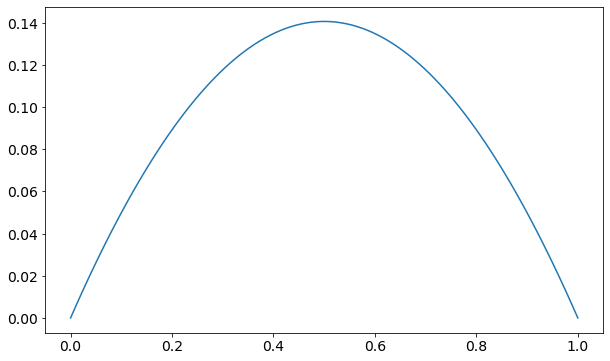

In [13]:
x_sol = np.linspace(0, 1, 100)
y_sol = sol.sol(x_sol)
# sol.sol return values for the whole system [f(x), df/dx]
plt.plot(x_sol, y_sol[0])

The Bratu problem has two solutions. The second can be found by changing the initial guess slightly.

In [14]:
# start with all zeroes
y = np.zeros((2, x.size))
# small change in initial guess
y[0] = 3

Now, solve the BVP again, compare the output and plot the two solutions.

In [22]:
x = np.linspace(0, 1, 10)
# start with all zeroes
y = np.zeros((2, x.size))
from scipy.integrate import solve_bvp

sol = solve_bvp(derivatives, bc, x, y,)

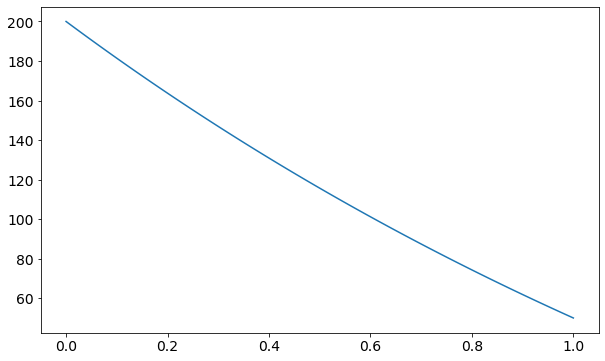

In [23]:
x_sol = np.linspace(0, 1, 100)
y_sol = sol.sol(x_sol)
# sol.sol return values for the whole system [f(x), df/dx]
plt.plot(x_sol, y_sol[0])

### Heat Exchanger Problem
(from the old bvp_solver tutorial)

Consider a device where heat is exchanged between two fluids. The hot fluid (with temperature $T_1$) enters from the left, moving to the right. The cold fluid (with temperature $T_2$) enters from the right, moving to the left. They exchange heat through a metal plate in between them. The cold fluid has twice the specific heat of the hot fluid. This system can be expressed as

$
\begin{align}
\large
q = U * (T_1 - T_2)
\end{align}
$

$
\begin{align}
\large
\frac{dT_1}{dx} = -q
\end{align}
$

$
\begin{align}
\large
\frac{dT_2}{dx} = \frac{-q}{2}
\end{align}
$

where $U$ is a coefficient of heat transfer.

The temperatures of the hot and cold fluids when they enter the device are known.

$
\begin{align}
\large
T_1(x = 0) = 200
\end{align}
$

$
\begin{align}
\large
T_2(x = L) = 50
\end{align}
$

Relevant constants are given below.

In [17]:
T1_0 = 200
T2_L = 50
L = 5
U = 1

Implement the derivatives and bounary conditions functions that describe this system.

In [18]:
def derivatives(x , y):
    """
    y[0] is T_1
    y[1] is T_2
    """
    q = U * (y[0] - y[1])
    return np.vstack((- q, - q / 2))
    
    
def bc(ya, yb):
    """
    ya is [T1, T2] on the left
    yb is [T1, T2] on the right
    """
    return np.array([ya[0]-200, yb[0]-50])
    

In [19]:
derivatives(x, y).shape

(2, 10)

Set an initial guess for the solution. Try $T_1(x) = T_1(0)$ and $T_2(x) = T_2(L)$.

In [20]:
x = np.linspace(0, L, 10)
y = np.empty([2, x.size])
y[0] = T1_0
y[1] = T2_L

Now find the solution and plot $T_1(x)$ and $T_2(x)$.

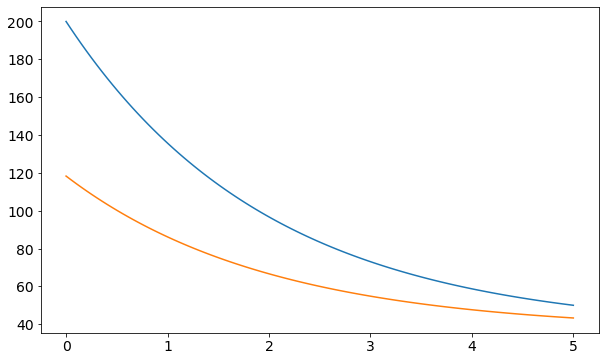

In [21]:
sol = solve_bvp(derivatives, bc, x, y,)
x_sol = np.linspace(0, L, 100)
y_sol = sol.sol(x_sol)
plt.plot(x_sol, y_sol[0])
plt.plot(x_sol, y_sol[1])

## Minimization

The [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module provides a number of options for finding function minima and maxima. The most relevant to our purposes is [minimize_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar).

Study the documentation of `minimize_scalar` and use it to find all local minima of the function below in the range [-10, 10]. Plot $f(x)$ to gain some intuition. Is there a more informative way to plot $f(x)$?

In [20]:
def f(x):
    return (x - 4*np.euler_gamma) * 0.5 * x * (x + np.e)**2 - 5*np.sin(3*x) + 11

In [21]:
from scipy.optimize import minimize_scalar

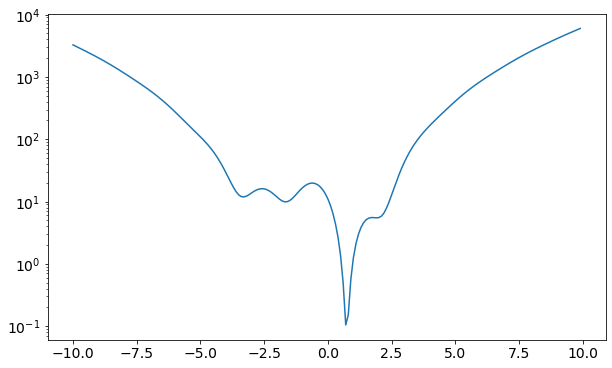

In [22]:
x = np.arange(-10, 10, 0.1)
y = f(x)
#plt.ylim(0,100)
plt.semilogy(x,y)
#plt.plot(x,y)

In [23]:
res = minimize_scalar(f, method = 'Brent', bracket = (-10, 0, 10))
sol_1 = res.x
res = minimize_scalar(f, method = 'Brent', bracket = (-5, -3, -2.5))
sol_2 = res.x
res = minimize_scalar(f, method = 'Brent', bracket = (0, 1, 2.5))
sol_3 = res.x
sol = np.array([sol_1, sol_2, sol_3])
print(sol)

[-1.65627449 -3.3207098   0.73763619]
